In [82]:
#importing libraries
import pandas as pd
import json
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize 
import os, json
import pandas as pd
## Cell computation timer
%load_ext autotime

def flatten_json(y):
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x
    flatten(y)
    return out

# || 2. Declare test data locations

A2=[]

json_files=[]

Data_Loc = r'C:\Users\Home\Documents\Second Spectrum Everton Project\Short Goal Kicks Project\everton_event_data'

for filename_with_ext in os.listdir(Data_Loc):
    
    if (filename_with_ext.endswith(".json")):  
        
        # get the file name without the extension
        filename = filename_with_ext.split('.')[0]
        json_files.append(filename)       

#json_files=json_files[7:10]

Events3=[]
Tactical_shift2=[]
Regular_Play2=[]
Counter_Attack2=[]
Corner2=[]
GoalKicks2=[]

for file in json_files:
    

# Reading the Events File
    f = open (r'C:\Users\Home\Documents\Second Spectrum Everton Project\Short Goal Kicks Project\everton_event_data/'+str(file)+'.json') 

    # Reading from file 
    data = json.loads(f.read()) 
    data1=flatten_json(data[0])
    D=[]

    for index, value in data1.items():

        B=value
        #A=A.replace("'", '"')
        #B=A.replace("True", 'true')
        #B=B.replace("False", 'false')

        try:
            C=json.loads(B)
            for i in C:
                i["index"]=index
        except:
            continue
        D.extend(C)    
    events = pd.concat([pd.DataFrame(D)])
    events['match_id']=str(file)

    #Applying a function to split the column stored as a dictionary and then use the concat function to bring back the columns into
    #the dataframe
    type1 = events.type.apply(pd.Series).set_axis(['type_id','type_name'], axis=1, inplace=False)
    possession_team = events.possession_team.apply(pd.Series).set_axis(['possession_id', 'possession_name'], axis=1, inplace=False)
    play_pattern = events.play_pattern.apply(pd.Series).set_axis(['play_pattern_id', 'play_pattern_name'], axis=1, inplace=False)
    pass_type=events['pass'].apply(pd.Series)
    play_type = pass_type.type.apply(pd.Series).set_axis(['','play_id', 'play_type'], axis=1, inplace=False)
    pass_type=pd.concat([pass_type.drop(['type'], axis=1), play_type], axis=1)
    del pass_type[0]
    team = events.team.apply(pd.Series).set_axis(['team_id', 'team_name'], axis=1, inplace=False)
    location = events.location.apply(pd.Series).set_axis(['x', 'y','z'], axis=1, inplace=False).fillna(0)
    player = events.player.apply(pd.Series).set_axis(['','player_id', 'player_name'], axis=1, inplace=False).fillna(0)
    position = events.position.apply(pd.Series).set_axis(['','position_id', 'position_name'], axis=1, inplace=False).fillna(0).drop(player.columns[0], axis = 1) 
    events1=pd.concat([events.drop(['type'], axis=1), type1], axis=1)
    events2=pd.concat([events1.drop(['possession_team'], axis=1), possession_team], axis=1)
    events3=pd.concat([events2.drop(['play_pattern'], axis=1), play_pattern], axis=1)
    events4=pd.concat([events3.drop(['team'], axis=1), team], axis=1)
    events5=pd.concat([events4.drop(['location'], axis=1), location], axis=1)
    events6=pd.concat([events5.drop(['player'], axis=1), player], axis=1)
    events7=pd.concat([events6.drop(['position'], axis=1), position], axis=1)
    events8=pd.concat([events7.drop(['pass'], axis=1), pass_type], axis=1)
    Start_events=[35,18]
    events = events8[~(events8['type_id'].isin(Start_events))].reset_index(drop=True)

    #Where do the next actions Go?
    events['next_event']=events['type_name'].shift(-1)
    events['next_event1']=events['type_name'].shift(-2)
    events['next_player']=events['player_name'].shift(-1)
    events['next_player1']=events['player_name'].shift(-2)
    #First action of sequence
    events['next_x']=events['x'].shift(-1).fillna(0)
    events['next_y']=events['y'].shift(-1).fillna(0)


    events['Team']=np.where(events['team_name']=='Everton','Everton','Opposition')

    #Normalizing Time in seconds and minutes
    events['time']=events['minute']+events['second']/60
    events.time=round(events.time,2)
    events['seconds']=events['minute']*60+events['second']
    
    
    bins = [-5,20,40,60,90,130]
    
    labels = ["H1","H2","H3","H4","H5"]
    events['H_zone']= pd.cut(events['x'], bins=bins, labels=labels)
    bins1 = [-5,13.84,54.16,80]
    labels1 = ["V1","V2","V3"]
    events['V_zone']= pd.cut(events['y'], bins=bins1, labels=labels1)
    
    #events['V_zone']=np.where(events['x']>60,events['V_zone']=='V4',events['V_zone'])
    events['zone_combo']=events['V_zone'].astype(str)+events['H_zone'].astype(str)
    
    col= 'zone_combo'
    conditions= [events[col] == 'V3H1', events[col] == 'V3H2', events[col] == 'V3H3',
                events[col] == 'V2H1',events[col] == 'V2H2',events[col] == 'V2H3',
                events[col] == 'V1H1',events[col] == 'V1H2',events[col] == 'V1H3',
                events[col] == 'V1H4',events[col] == 'V2H4',events[col] == 'V3H4',
                events[col] == 'V1H5',events[col] == 'V2H5',events[col] == 'V3H5']
    choices= [1, 2,3,4,5,6,7,8,9,10,10,10,11,11,11]

    events["zone_final"] = np.select(conditions, choices, default=0)
    events["zone_final1"] = events["zone_final"].shift(-1).fillna(0)
    ### Look ahead by 10 actions ####
    
    #events["zone_final1"] = events["zone_final0"].shift(-1).fillna(0)
    #events["zone_final2"] = events["zone_final1"].shift(-1).fillna(0)
    #events["zone_final3"] = events["zone_final2"].shift(-1).fillna(0)
    #events["zone_final4"] = events["zone_final3"].shift(-1).fillna(0)
    #events["zone_final5"] = events["zone_final4"].shift(-1).fillna(0)
    #events["zone_final6"] = events["zone_final5"].shift(-1).fillna(0)
    #events["zone_final7"] = events["zone_final6"].shift(-1).fillna(0)
    #events["zone_final8"] = events["zone_final7"].shift(-1).fillna(0)
    #events["zone_final9"] = events["zone_final8"].shift(-1).fillna(0)
    #events["zone_final10"] = events["zone_final9"].shift(-1).fillna(0)
    
    
    #Assigning Proxy associated to x-axis (three Vertical zones)
    bins = [0,40,80,121]
    labels = ["Defensive-Third","Middle-Third","Offensive-Third"]
    events['x_zone']= pd.cut(events['x'], bins=bins, labels=labels)
    events['next_x_zone']=events['x_zone'].shift(-1)
    #Second action of sequence
    events['next_x1']=events['x'].shift(-2).fillna(0)
    events['next_y1']=events['y'].shift(-2).fillna(0)
    #Third action of sequence
    events['next_x2']=events['x'].shift(-3).fillna(0)
    events['next_y2']=events['y'].shift(-3).fillna(0)
    #Fourth action of sequence
    events['next_x3']=events['x'].shift(-4).fillna(0)
    events['next_y3']=events['y'].shift(-4).fillna(0)
    #Fifth action of sequence
    events['next_x4']=events['x'].shift(-5).fillna(0)
    events['next_y4']=events['y'].shift(-5).fillna(0)
    
  

    bins1 = [0,12,24,55,68,80]
    labels1 = ["Right","Right-Half-Space","Middle","Left-Half-Space","Left"]
    events['y_zone']= pd.cut(events['y'], bins=bins1, labels=labels1)
    events['next_y_zone']=events['y_zone'].shift(-1)
    #Subsetting data for open play and closed play
    events['play_pattern_count'] = events.groupby((events['play_pattern_name'] != events['play_pattern_name'].shift(1)).cumsum()).cumcount()+1
    events['play_pattern_name1']=events['play_pattern_name'].shift(-1)
    #Subsetting times for Goal Kicks, Corner Kicks, Free Kicks to sync with tracking data: #Miscellaneous Information

    def add_distance_to_ball(events):

        events['distance'] = events[['x', 'y']].sub(np.array(events[['next_x', 'next_y']] )).pow(2).sum(1).pow(0.5)
        events.distance = events.distance.round(2)
        return(events)

    events=add_distance_to_ball(events)

    ################### Only look at shots ###################
    Events=events
    Shots=Events[Events['type_name']=='Shot'].reset_index(drop=True)

    D=[]

    for index, row in Shots.iterrows():

        A=row['shot']
        C=pd.DataFrame.from_dict(A,orient='index')
        C=C.T
        D.append(C)
        
    D=pd.concat(D).reset_index(drop=True)
    Events1=pd.merge(Shots,D[['statsbomb_xg']],left_index=True,right_index=True)
    Events2=pd.merge(Events1[['id','statsbomb_xg']],Events,on='id',how='right')
    
    ###### Keep only columns in list ########
    
    cols_list=['id','statsbomb_xg','timestamp','minute','second','seconds','duration','match_id','type_name','possession_name','play_pattern_name','team_name','x','y','z','player_id','player_name','position_id','position_name','height','outcome','recipient','play_type','next_event','next_event1','next_player','next_player1','next_x','next_y','time','x_zone','next_x_zone','next_x1','next_y1',
               'next_x2','next_y2','next_x3','next_y3','next_x4','next_y4','y_zone','next_y_zone','play_pattern_count','distance','zone_final','zone_final1']
    Events2=Events2[cols_list].reset_index(drop=True)
    
    
    ##### Getting all the other phases of play #####
    
    GoalKicks1=Events2[(Events2['play_pattern_name']=='From Goal Kick')]
    Corner1=Events2[Events2['play_pattern_name']=='From Corner']
    FreeKicks1=Events2[Events2['play_pattern_name']=='From Free Kick']
    Counter_Attack1=Events2[Events2['play_pattern_name']=='From Counter']
       

    ##### Appending the event datasets from matches #####
    
    #Regular_Play2.append(Regular_Play1)
    Counter_Attack2.append(Counter_Attack1)
    Corner2.append(Corner1)
    GoalKicks2.append(GoalKicks1)

    Events3.append(Events2)
    #Events2.to_csv(r'C:\Users\Home\Documents\Second Spectrum Everton Project\Short Goal Kicks Project\everton event data converted/'+str(file)+'.csv')

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 6min 29s


##### Points to remember ######
1) play pattern count will start at 1 every time play type is Goal Kick
2) Have to identify time when zone 10 has been breached 
3) Create a matrix of zone interactions
4) Number of offensive actions until team reaches opposition half 
5) Subset short goal kicks using height indicator (High/Low Pass) 

In [83]:
#Creating DataFrames from the lists
GoalKicks3=pd.concat(GoalKicks2)
#Events3=pd.concat(Events3)

time: 101 ms


In [103]:
GoalKicks3['Team']=np.where(GoalKicks3.team_name!='Everton','Opposition','Everton')

time: 3.98 ms


In [109]:
GoalKicks3[['Null1','outcome_id','outcome_name']]=GoalKicks3['outcome'].apply(pd.Series)
#del GoalKicks3['Null1']

time: 3.09 s


In [110]:
GK1=GoalKicks3[(GoalKicks3['play_type']=='Goal Kick')].reset_index(drop=True)
GK1['sequence']=GK1.index

### Subset list of sequences ###
list_of_seq=list(GK1['sequence'].unique())

#### Merge two dataframes to get sequence ids for goal kicks ####
GK2=pd.merge(GoalKicks3,GK1[['id','sequence']], on='id',how='left')
GK2['sequence']=GK2['sequence'].fillna(method='ffill')

### Subset data for sequence ###
notin=[0,10,11,3,6,9]

GK4=GK2[(GK2['play_type']=='Goal Kick') & (~GK2['zone_final1'].isin(notin))
              & (GK2['next_event']=='Ball Receipt*')].reset_index(drop=True)

### Subset list of sequences ###
list_of_seq=list(GK4['sequence'].unique())

GK3=GK2[GK2['sequence'].isin(list_of_seq)].reset_index(drop=True)
GK3.sequence.unique()

array([  0.,   1.,   5.,   7.,   8.,  12.,  13.,  15.,  16.,  20.,  23.,
        24.,  26.,  27.,  29.,  32.,  33.,  35.,  36.,  37.,  38.,  46.,
        49.,  52.,  53.,  54.,  55.,  58.,  60.,  61.,  63.,  64.,  65.,
        66.,  68.,  76.,  80.,  85.,  87.,  89., 101., 104., 106., 107.,
       109., 111., 115., 121., 124., 126., 127., 128., 135., 138., 140.])

time: 240 ms


In [111]:
GoalKicks3.type_name.unique()

array(['Pass', 'Ball Receipt*', 'Pressure', 'Carry', 'Ball Recovery',
       'Duel', 'Clearance', 'Miscontrol', 'Foul Committed', 'Foul Won',
       'Block', 'Dribbled Past', 'Dribble', 'Shot', 'Dispossessed',
       'Tactical Shift', 'Interception', 'Half End', 'Injury Stoppage',
       'Substitution', 'Goal Keeper', 'Shield'], dtype=object)

time: 4.96 ms


In [113]:
A=[]
B=[]
C=[]

for i in list_of_seq:
    
    Subset=Subset.sort_values(['time'], ascending=[True])
    Subset=GK3[GK3['sequence']==i].reset_index(drop=True)
    #Subset=GK3[GK3['sequence']==i].reset_index(drop=True)
    Subset['rolling']=Subset['seconds'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0)
    Subset['cumsum'] = Subset['rolling'].cumsum()
    rolling=Subset[['sequence','play_pattern_count','rolling','zone_final','cumsum',
                    'position_name','type_name','player_name','time','team_name','play_type','outcome_name']]
    
rolling

sequence  play_pattern_count  rolling  zone_final  cumsum  \
0      140.0                   1      0.0           4     0.0   
1      140.0                   2      1.0           4     1.0   
2      140.0                   3      0.0           4     1.0   
3      140.0                   4      1.0           4     2.0   
4      140.0                   5      2.0           4     4.0   
5      140.0                   6      0.0           4     4.0   
6      140.0                   7      7.0           1    11.0   
7      140.0                   8      1.0           1    12.0   
8      140.0                   9      0.0           1    12.0   
9      140.0                  10      4.0           2    16.0   
10     140.0                  11      2.0           2    18.0   
11     140.0                  12      0.0           2    18.0   
12     140.0                  13      1.0           2    19.0   
13     140.0                  14      2.0           9    21.0   
14     140.0                  15      0.0           9    21.0   
15     140.0                  16      4.0           6    25.0   
16     140.0                  17      2.0           6    27.0   
17     140.0                  18      0.0           6    27.0   
18     140.0                  19      1.0           6    28.0   
19     140.0                  20      1.0           6    29.0   
20     140.0                  21      0.0           6    29.0   
21     140.0                  22      1.0           6    30.0   
22     140.0                  23      1.0          10    31.0   
23     140.0                  24      0.0          10    31.0   
24     140.0                  25      2.0          10    33.0   
25     140.0                  26      1.0           9    34.0   
26     140.0                  27      0.0           9    34.0   
27     140.0                  28      1.0           9    35.0   
28     140.0                  29      2.0           6    37.0   
29     140.0                  30      0.0           6    37.0   
30     140.0                  31      1.0           6    38.0   
31     140.0                  32      1.0          10    39.0   
32     140.0                  33      0.0          10    39.0   
33     140.0                  34      2.0          10    41.0   
34     140.0                  35      1.0          10    42.0   
35     140.0                  36      0.0          10    42.0   
36     140.0                  37      1.0          10    43.0   
37     140.0                  38      0.0          10    43.0   
38     140.0                  39      5.0          10    48.0   
39     140.0                  40      1.0           6    49.0   
40     140.0                  41      0.0           6    49.0   
41     140.0                  42      3.0           6    52.0   
42     140.0                  43      2.0           6    54.0   
43     140.0                  44      0.0           6    54.0   
44     140.0                  45      2.0          10    56.0   
45     140.0                  46      1.0          10    57.0   
46     140.0                  47      0.0          10    57.0   
47     140.0                  48      3.0          10    60.0   
48     140.0                  49      1.0          10    61.0   
49     140.0                  50      0.0          10    61.0   
50     140.0                  51      3.0          10    64.0   
51     140.0                  52      2.0          11    66.0   
52     140.0                  53      0.0          11    66.0   
53     140.0                  54      0.0          11    66.0   
54     140.0                  55      2.0          10    68.0   
55     140.0                  56      0.0          10    68.0   
56     140.0                  57      1.0          10    69.0   

                position_name      type_name                     player_name  \
0                  Goalkeeper           Pass                 Jordan Pickford   
1       Right Center Midfield  Ball Receipt*      André Filipe Tavares Go

time: 328 ms


In [32]:
GK3.play_type.unique()

### Defining success of reaching zone 10 ####
"""A failed possession sequence is filtered to include the time between the snap (GK) and the earliest of the following:

1) A throw-in (Failure)
2) A non-throwin, play-ending event (such as a foul or dispossession)
3) A dispossession before reaching zone 10

Success is defined as sustained possession in zone 10 and teams can gain or lose yardage after reaching zone 10- what we're
defining as sustained possession



array(['Goal Kick', nan, 'Recovery', 'Interception'], dtype=object)

time: 8.5 ms


In [12]:
Subset.time.unique()

array([92.08, 92.1 , 92.12, 92.15, 92.27, 92.28, 92.35, 92.38, 92.4 ,
       92.43, 92.5 , 92.53, 92.55, 92.57, 92.58, 92.6 , 92.63, 92.65,
       92.67, 92.7 , 92.72, 92.73, 92.77, 92.78, 92.8 , 92.88, 92.9 ,
       92.95, 92.98, 93.02, 93.03, 93.08, 93.1 , 93.15, 93.18, 93.22,
       93.23])

time: 5.42 ms


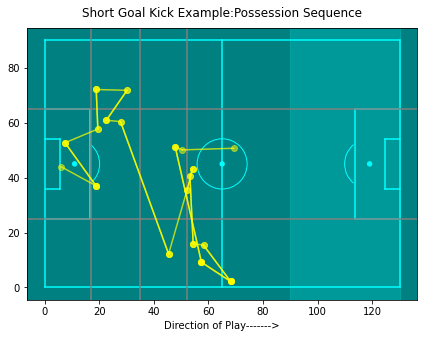

time: 502 ms


In [9]:
from matplotlib.patches import Arc

#Where does the keeper pass to from Goal Kicks?
#GK3=GK2[GK2['sequence']==45][:1]
GoalKicks_receipts=Subset[Subset['type_name']=='Pass'][:10]

#Create figure
fig=plt.figure()
fig.set_size_inches(7, 5)
ax=fig.add_subplot(1,1,1)
plt.rcParams['axes.facecolor'] = 'Cyan'
ax.set_facecolor('teal')

#Pitch Outline & Centre Line
plt.plot([0,0],[0,90], color="cyan")
plt.plot([0,130],[90,90], color="cyan")
plt.plot([130,130],[90,0], color="cyan")
plt.plot([130,0],[0,0], color="cyan")
plt.plot([65,65],[0,90], color="cyan")

#Left Penalty Area
plt.plot([16.5,16.5],[65,25],color="cyan")
plt.plot([0,16.5],[65,65],color="cyan")
plt.plot([16.5,0],[25,25],color="cyan")

#Right Penalty Area
plt.plot([130,113.5],[65,65],color="cyan")
plt.plot([113.5,113.5],[65,25],color="cyan")
plt.plot([113.5,130],[25,25],color="cyan")

#Left 6-yard Box
plt.plot([0,5.5],[54,54],color="cyan")
plt.plot([5.5,5.5],[54,36],color="cyan")
plt.plot([5.5,0.5],[36,36],color="cyan")

#Right 6-yard Box
plt.plot([130,124.5],[54,54],color="cyan")
plt.plot([124.5,124.5],[54,36],color="cyan")
plt.plot([124.5,130],[36,36],color="cyan")

#Prepare Circles
centreCircle = plt.Circle((65,45),9.15,color="cyan",fill=False)
centreSpot = plt.Circle((65,45),0.8,color="cyan")
leftPenSpot = plt.Circle((11,45),0.8,color="cyan")
rightPenSpot = plt.Circle((119,45),0.8,color="cyan")

#Draw Circles
ax.add_patch(centreCircle)
ax.add_patch(centreSpot)
ax.add_patch(leftPenSpot)
ax.add_patch(rightPenSpot)
plt.axvline(x=35,color="grey")
plt.axvline(x=52,color="grey")
plt.axvline(x=17,color="grey")

plt.axhline(y=25,color="grey")
plt.axhline(y=65,color="grey")
#plt.axhline(y=54,alpha=0.1,color="black")
#plt.axhline(y=74,alpha=0.1,color="black")


#Prepare Arcs
leftArc = Arc((11,45),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color="cyan")
rightArc = Arc((119,45),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color="cyan")

#Draw Arcs
ax.add_patch(leftArc)
ax.add_patch(rightArc)

#Tidy Axes
#plt.axis('off')
#plt.xticks([])
#plt.yticks([])

#for i in range(len(GoalKicks_receipts)):
               
#for i in range(number_of_colors):

plt.plot([(GoalKicks_receipts["x"]),(GoalKicks_receipts["next_x"])],[(GoalKicks_receipts["y"]),(GoalKicks_receipts["next_y"])], color='yellow',alpha=0.7)
plt.plot([(GoalKicks_receipts["next_x"]),(GoalKicks_receipts["next_x1"])],[(GoalKicks_receipts["next_y"]),(GoalKicks_receipts["next_y1"])], color='yellow',alpha=0.7)
plt.plot([(GoalKicks_receipts["next_x1"]),(GoalKicks_receipts["next_x2"])],[(GoalKicks_receipts["next_y1"]),(GoalKicks_receipts["next_y2"])], color='yellow',alpha=0.7)
plt.plot([(GoalKicks_receipts["next_x2"]),(GoalKicks_receipts["next_x3"])],[(GoalKicks_receipts["next_y2"]),(GoalKicks_receipts["next_y3"])], color='yellow',alpha=0.7)
plt.plot((GoalKicks_receipts["next_x"]),(GoalKicks_receipts["next_y"]),"o", color="yellow",alpha=0.5)
plt.plot((GoalKicks_receipts["x"]),(GoalKicks_receipts["y"]),"o", color="yellow",alpha=0.5)
plt.plot((GoalKicks_receipts["next_x1"]),(GoalKicks_receipts["next_y1"]),"o", color="yellow",alpha=0.5)
plt.plot((GoalKicks_receipts["next_x2"]),(GoalKicks_receipts["next_y2"]),"o", color="yellow",alpha=0.5)
plt.plot((GoalKicks_receipts["next_x3"]),(GoalKicks_receipts["next_y3"]),"o", color="yellow",alpha=0.5)
plt.axvspan(90, 130, alpha=0.2, color='cyan')
plt.xlabel('Direction of Play------->')
plt.title("Short Goal Kick Example:Possession Sequence", y=1.02);#x = GoalKicks_receipts.x.values*1.083


#Display Pitch
plt.show()

In [81]:
GK3.to_csv(r'C:\Users\Home\Documents\D.csv')

time: 932 ms


##### Add later on if necessary ####


In [ ]:
 ### Look ahead by 10 actions ####
    
    #events["zone_final1"] = events["zone_final0"].shift(-1).fillna(0)
    #events["zone_final2"] = events["zone_final1"].shift(-1).fillna(0)
    #events["zone_final3"] = events["zone_final2"].shift(-1).fillna(0)
    #events["zone_final4"] = events["zone_final3"].shift(-1).fillna(0)
    #events["zone_final5"] = events["zone_final4"].shift(-1).fillna(0)
    #events["zone_final6"] = events["zone_final5"].shift(-1).fillna(0)
    #events["zone_final7"] = events["zone_final6"].shift(-1).fillna(0)
    #events["zone_final8"] = events["zone_final7"].shift(-1).fillna(0)
    #events["zone_final9"] = events["zone_final8"].shift(-1).fillna(0)
    #events["zone_final10"] = events["zone_final9"].shift(-1).fillna(0)
    
    
    #Assigning Proxy associated to x-axis (three Vertical zones)
    #bins = [0,40,80,121]
    labels = ["Defensive-Third","Middle-Third","Offensive-Third"]
    events['x_zone']= pd.cut(events['x'], bins=bins, labels=labels)
    events['next_x_zone']=events['x_zone'].shift(-1)
    #Second action of sequence
    events['next_x1']=events['x'].shift(-2).fillna(0)
    events['next_y1']=events['y'].shift(-2).fillna(0)
    #Third action of sequence
    events['next_x2']=events['x'].shift(-3).fillna(0)
    events['next_y2']=events['y'].shift(-3).fillna(0)
    #Fourth action of sequence
    events['next_x3']=events['x'].shift(-4).fillna(0)
    events['next_y3']=events['y'].shift(-4).fillna(0)
    #Fifth action of sequence
    events['next_x4']=events['x'].shift(-5).fillna(0)
    events['next_y4']=events['y'].shift(-5).fillna(0)
    
  

    bins1 = [0,12,24,55,68,80]
    labels1 = ["Right","Right-Half-Space","Middle","Left-Half-Space","Left"]
    events['y_zone']= pd.cut(events['y'], bins=bins1, labels=labels1)
    events['next_y_zone']=events['y_zone'].shift(-1)
    #Subsetting data for open play and closed play
    events['play_pattern_count'] = events.groupby((events['play_pattern_name'] != events['play_pattern_name'].shift(1)).cumsum()).cumcount()+1
    events['play_pattern_name1']=events['play_pattern_name'].shift(-1)
    #Subsetting times for Goal Kicks, Corner Kicks, Free Kicks to sync with tracking data: #Miscellaneous Information
